In [1]:
import csv
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
import itertools

# Helper Methods
To lead an easy, fulfilling life

In [2]:
# ridge regression
# serves as least squares when lambda = 0
def ridge(X, y, lamb=0):
    return np.linalg.inv(X.T @ X + lamb * np.eye(np.shape(X)[1])) @ X.T @ y

# does ridge regression
# returns a predictor function (makes cross val easier)
def ridge_pred(X, y, lamb=0):
    weights = ridge(X, y, lamb)
    # predicts values given input data
    def pred(X_pred):
        return X_pred @ weights
    return pred

def en_pred(X,y, alpha=1, l1_ratio=0.5):
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    model.fit(X, y)
    def pred(X_pred):
        return model.predict(X_pred)
    return pred

#Regression Tree
def reg_tree(X,y,max_depth = None, min_samples_leaf=1):
    model = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    model.fit(X,y)
    return model

#Creates a regression tree
#Return predictor function to sue with cross_val function
def tree_pred(X,y,max_depth=None, min_samples_leaf=1):
    model = reg_tree(X,y,max_depth)
    def pred(X_pred):
        return model.predict(X_pred)
    return pred

# this is definitely overcomplicated, but
# reg is a function that returns a predictor
# args are the extra args that should be passed into reg
def cross_val(X, y, reg, folds=5, **args):
    X = np.hstack((X, np.ones((len(X), 1))))
    y_pred_all = np.array([])
    errors = []
    len_data = len(y)
    fold_size = math.ceil(len_data / folds)
    for i in range(0, len_data, fold_size):
        X_train = np.vstack((X[:i], X[i+fold_size:]))
        y_train = np.concatenate((y[:i], y[i+fold_size:]))
        X_test = X[i:i+fold_size]
        y_test = y[i:i+fold_size]
        
        pred = reg(X_train, y_train, **args)
        y_pred = pred(X_test)
        y_pred = y_pred.flatten()  # reshape for easy concatenation
        y_test = y_test.flatten()
        error = sum((y_test - y_pred)**2)/len(y_pred)
        y_pred_all = np.concatenate((y_pred_all, y_pred))
        errors.append(error)
    return np.mean(errors), y_pred_all

In [3]:
# given X, y, and predicted y, along with labels for features
# generates relevant plots
def plot_results(X, y, y_pred, labels):
    # per feature results
    for i, xrow in enumerate(X[:-1].T):
        plt.figure()
        plt.title(labels[i])
        for x, a, b in zip(xrow, y, y_pred):
            plt.plot(x, a, 'r.')
            plt.plot(x, b, 'b.')
        plt.show()
    
    # top PCA plot
    U, Sigma, V = np.linalg.svd(X.T)
    X1 = U[:, :1].T @ X.T

    plt.figure()
    plt.title('PCA dim 1')
    for x, a, b in zip(X1.T, y, y_pred):
        plt.plot(x[0], a, 'r.')
        plt.plot(x[0], b, 'b.')
    plt.show()
    
    plt.figure()
    plt.title('Predicted vs True')
    plt.plot(y, y_pred, 'b.')
    mi = min(np.min(y), np.min(y_pred))
    ma = max(np.max(y), np.max(y_pred))
    plt.plot([mi, ma], [mi, ma], 'r')
    plt.show()
    

# Loading the Data
Data is loaded into data as floats.
Labels are kept around to label the plots

In [4]:
data = []
labels = []
with open('bs_clean.csv') as datafile:
    rows = csv.reader(datafile)
    for i, row in enumerate(rows):
        if i == 0:
            labels = row[1:]
        try:
            data.append([float(r) for r in row[1:]])
        except ValueError:
            continue
data = np.array(data[1:])
data = data.T


# Least Squares Regression

Your regular garden-variety least squares

In [5]:
X = data[:-1].T
y = data[-1:].T

# lambda = 0 means least squares regression
error, y_pred = cross_val(X, y, folds=5, reg=ridge_pred, lamb=0)

print('Least Squares Error is {}'.format(error))


Least Squares Error is 7499.8438944254885


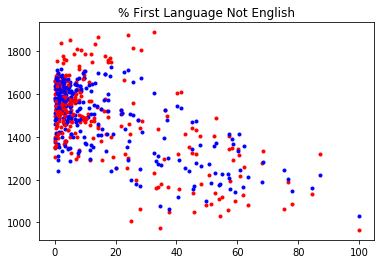

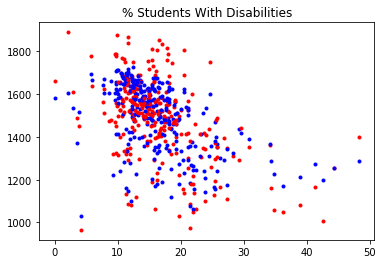

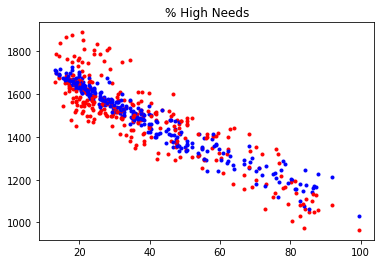

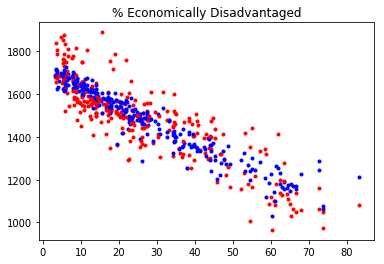

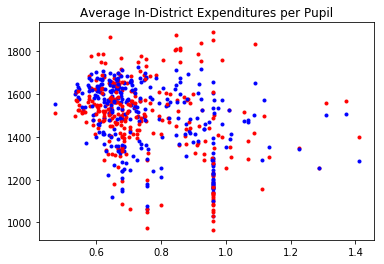

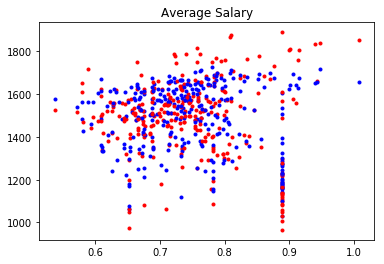

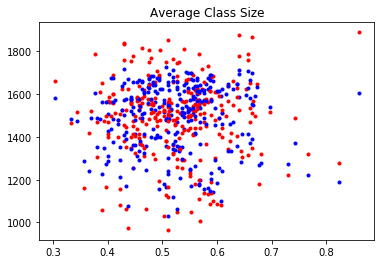

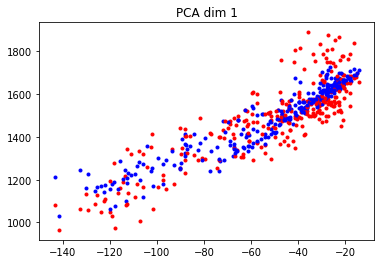

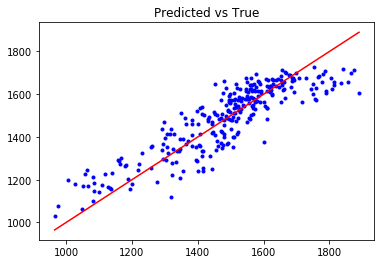

In [6]:
plot_results(X, y, y_pred, labels)

# Elastic Net Regression

Combines least squares with L1 and L2 regularization.

In sklearn, alpha represents the regularization parameter and l1_ratio represents how much to apply to l1 vs l2, or in other words:

$ alpha = l1 + l2 $

$ l_1ratio = \frac{l1}{l1 + l2} $

In [7]:
alphas = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ratios = np.linspace(0, 1, 11)
param_permutations = list(itertools.product(alphas, ratios))
errors = []
for a, r in param_permutations:
    err, y_pred = cross_val(X, y, en_pred, alpha=a, l1_ratio=r)
    print('Elastic net regression error is', err, 'for alpha =', a, 'and l1_ratio =', r)
    errors.append(err)
min_ind = np.argmin(errors)
alpha, ratio = param_permutations[min_ind]
err, y_pred = cross_val(X, y, en_pred, alpha=alpha, l1_ratio=ratio)
print('Optimal parameters: alpha =', alpha, ' l1_ratio =', ratio)
print('Error is', err)

C:\Users\Justin\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Elastic net regression error is 7173.339923113429 for alpha = 1 and l1_ratio = 0.0
Elastic net regression error is 7170.218198782427 for alpha = 1 and l1_ratio = 0.1
Elastic net regression error is 7167.345992612219 for alpha = 1 and l1_ratio = 0.2
Elastic net regression error is 7164.615352442616 for alpha = 1 and l1_ratio = 0.30000000000000004
Elastic net regression error is 7162.219381263069 for alpha = 1 and l1_ratio = 0.4
Elastic net regression error is 7160.305313155855 for alpha = 1 and l1_ratio = 0.5
Elastic net regression error is 7159.988148589546 for alpha = 1 and l1_ratio = 0.6000000000000001
Elastic net regression error is 7159.8833366910285 for alpha = 1 and l1_ratio = 0.7000000000000001
Elastic net regression error is 7160.680789034277 for alpha = 1 and l1_ratio = 0.8
Elastic net regression error is 7166.867423202535 for alpha = 1 and l1_ratio = 0.9
Elastic net regression error is 7205.993350589983 for alpha = 1 and l1_ratio = 1.0
Elastic net regression error is 7211.693

Interestingly, cross validation results in an L1 ratio of 1, meaning ony the L1 regularization applies (standard LASSO). 

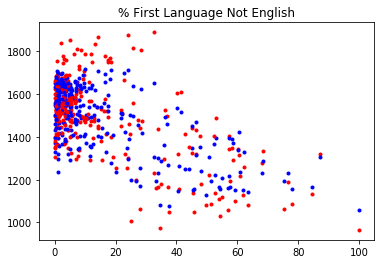

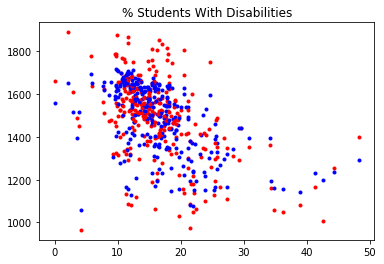

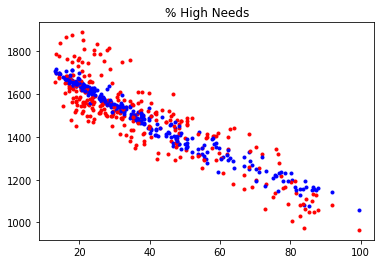

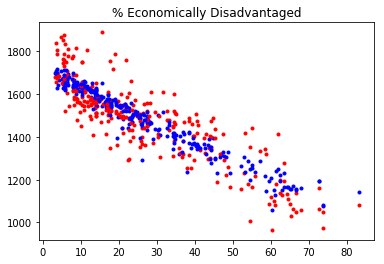

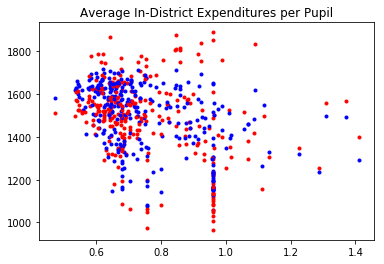

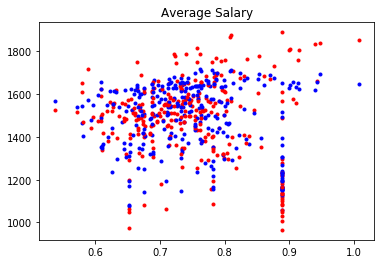

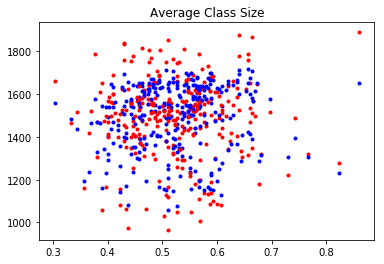

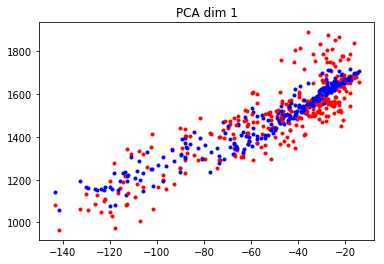

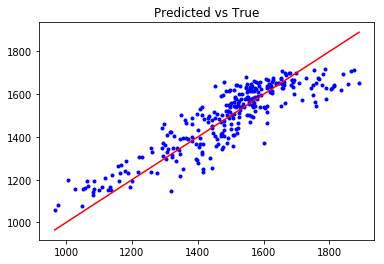

In [8]:
plot_results(X, y, y_pred, labels)

# Regression Tree



Regression Tree Error is 9822.071531367628 for max_depth 3 and samples 0.01
Regression Tree Error is 9822.071531367628 for max_depth 3 and samples 0.1
Regression Tree Error is 9822.071531367628 for max_depth 3 and samples 0.2
Regression Tree Error is 9822.071531367628 for max_depth 3 and samples 0.3
Regression Tree Error is 9822.071531367628 for max_depth 3 and samples 1
Regression Tree Error is 9936.312859369451 for max_depth 4 and samples 0.01
Regression Tree Error is 9917.872463889225 for max_depth 4 and samples 0.1
Regression Tree Error is 9860.866531685835 for max_depth 4 and samples 0.2
Regression Tree Error is 9929.946757674536 for max_depth 4 and samples 0.3
Regression Tree Error is 9861.883480838378 for max_depth 4 and samples 1
Regression Tree Error is 9892.621224299497 for max_depth 5 and samples 0.01
Regression Tree Error is 9708.065970062209 for max_depth 5 and samples 0.1
Regression Tree Error is 10018.319288329629 for max_depth 5 and samples 0.2
Regression Tree Error is 

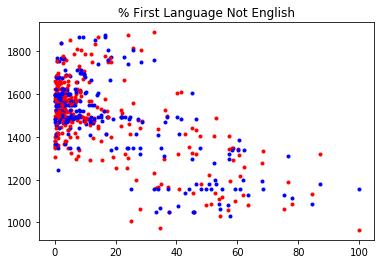

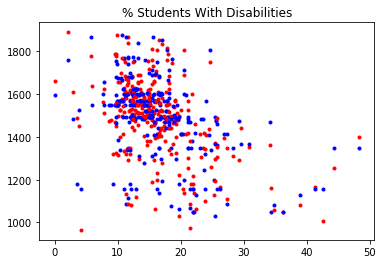

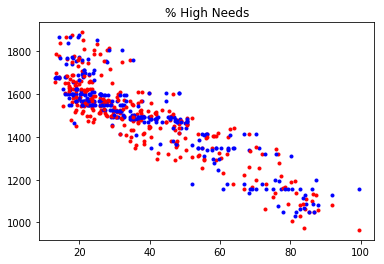

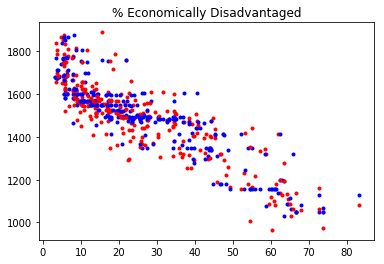

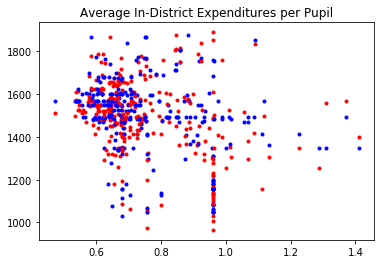

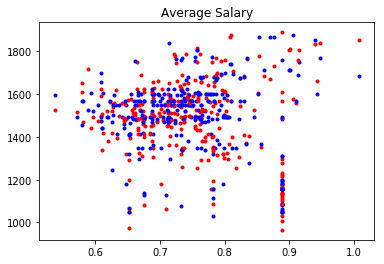

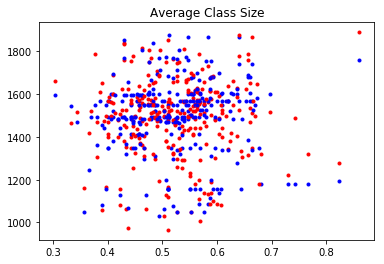

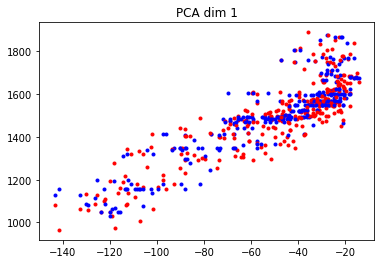

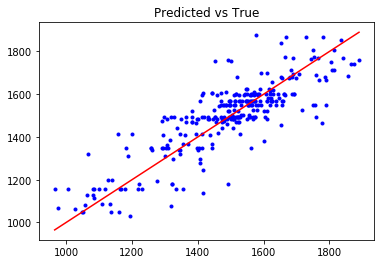

In [9]:
depths = [3,4,5,6,7,8,None]
samples = [0.01, .1, 0.2, 0.3, 1]
param_permuations = list(itertools.product(depths, samples))
#parameter variations for cross validation
errors = []
for m,s in param_permuations:
    error, y_pred = cross_val(X, y, folds=5, reg=tree_pred, max_depth=m, min_samples_leaf=s)
    print('Regression Tree Error is {} for max_depth {} and samples {}'.format(error, m, s))
    errors.append(error)
    
idx = np.argmin(errors)
best_params = param_permuations[idx]
print('Best parameters found for Regression Tree is {} max_depth and {} min_samples_leaf'.format(best_params[0], best_params[1]))

error, y_pred = cross_val(X, y, folds=5, reg=tree_pred, max_depth=best_params[0], min_samples_leaf=best_params[1])

plot_results(X, y, y_pred, labels)

# Cleaning Data
-  Select Necessary Columns
-  Add SAT scores for one prediction value
-  Scale features to roughly fall from 0 to 1

In [10]:
dataset = pd.read_csv('MA_Public_Schools_2017.csv')


In [11]:
for c in dataset.columns:
    print(c)

School Code
School Name
School Type
Function
Contact Name
Address 1
Address 2
Town
State
Zip
Phone
Fax
Grade
District Name
District Code
PK_Enrollment
K_Enrollment
1_Enrollment
2_Enrollment
3_Enrollment
4_Enrollment
5_Enrollment
6_Enrollment
7_Enrollment
8_Enrollment
9_Enrollment
10_Enrollment
11_Enrollment
12_Enrollment
SP_Enrollment
TOTAL_Enrollment
First Language Not English
% First Language Not English
English Language Learner
% English Language Learner
Students With Disabilities
% Students With Disabilities
High Needs
% High Needs
Economically Disadvantaged
% Economically Disadvantaged
% African American
% Asian
% Hispanic
% White
% Native American
% Native Hawaiian, Pacific Islander
% Multi-Race, Non-Hispanic
% Males
% Females
Total # of Classes
Average Class Size
Number of Students
Salary Totals
Average Salary
FTE Count
In-District Expenditures
Total In-district FTEs
Average In-District Expenditures per Pupil
Total Expenditures
Total Pupil FTEs
Average Expenditures per Pupil
# i

In [12]:
datasmall = dataset[[
    '% First Language Not English',
    '% Students With Disabilities',
    '% High Needs',
    '% Economically Disadvantaged',
    'Average In-District Expenditures per Pupil',
    'Average Salary',
    'Average Class Size',
    'Average SAT_Reading',
    'Average SAT_Writing',
    'Average SAT_Math',
]] # select necessary columns
datasmall = datasmall[:][~np.isnan(datasmall['Average SAT_Reading'])] # filter for high schools
datasmall['SAT'] = datasmall['Average SAT_Reading'] + datasmall['Average SAT_Math'] + datasmall['Average SAT_Writing'] # find SAT score
datasmall = datasmall.drop(['Average SAT_Reading', 'Average SAT_Math', 'Average SAT_Writing'], axis='columns') # drop unnecessary columns
datasmall['Average Salary'] /= 100000 # rudimentary scaling
datasmall['Average Class Size'] /= 30
datasmall['Average In-District Expenditures per Pupil'] /= 20000

for c in datasmall.columns:
    print(c)

% First Language Not English
% Students With Disabilities
% High Needs
% Economically Disadvantaged
Average In-District Expenditures per Pupil
Average Salary
Average Class Size
SAT


In [13]:
datasmall.to_csv('bs_clean.csv')


In [14]:
datasmall['SAT']

0       1534.0
8       1485.0
16      1583.0
23      1709.0
33      1749.0
43      1655.0
50      1488.0
60      1470.0
64      1399.0
66      1507.0
74      1688.0
78      1619.0
84      1513.0
89      1781.0
99      1551.0
106     1577.0
115     1179.0
120     1299.0
122     1217.0
123      965.0
124     1890.0
125     1610.0
127     1101.0
131     1128.0
134     1051.0
142     1162.0
145     1006.0
148     1188.0
153     1109.0
154     1222.0
         ...  
1659    1807.0
1661    1454.0
1672    1813.0
1675    1552.0
1679    1510.0
1688    1474.0
1695    1768.0
1706    1556.0
1707    1309.0
1717    1786.0
1721    1834.0
1732    1683.0
1745    1504.0
1753    1516.0
1755    1371.0
1763    1549.0
1768    1383.0
1778    1790.0
1781    1444.0
1792    1492.0
1796    1355.0
1802    1085.0
1805    1405.0
1822    1193.0
1826    1345.0
1831    1334.0
1838    1291.0
1851    1552.0
1854    1233.0
1858    1477.0
Name: SAT, Length: 332, dtype: float64

# Random old code blocks

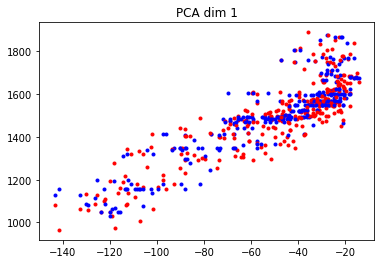

In [15]:
U, Sigma, V = np.linalg.svd(X.T)
X1 = U[:, :1].T @ X.T

plt.figure()
plt.title('PCA dim 1')
for x, a, b in zip(X1.T, y, y_pred):
    plt.plot(x[0], a, 'r.')
    plt.plot(x[0], b, 'b.')
plt.show()


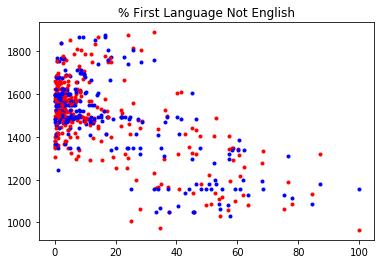

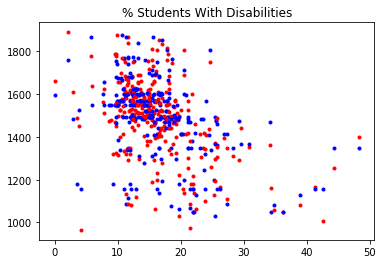

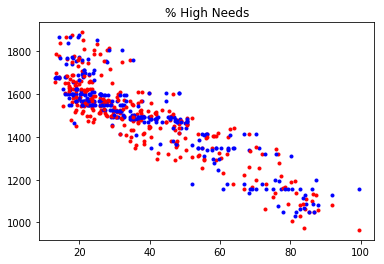

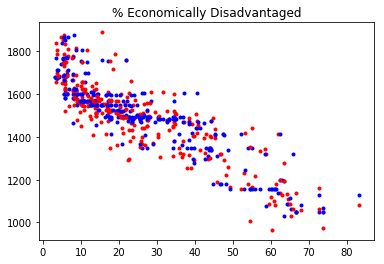

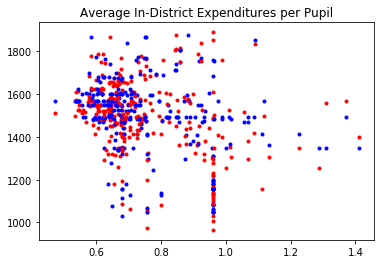

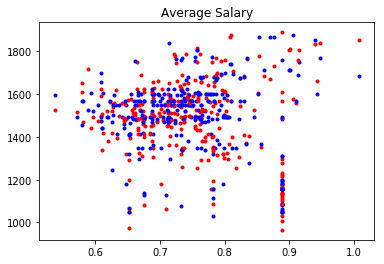

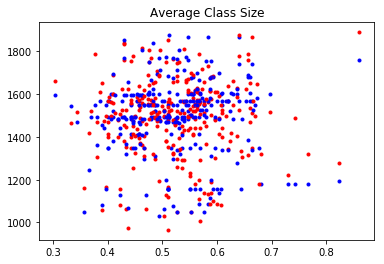

In [16]:
for i, xrow in enumerate(X[:-1].T):
    plt.figure()
    plt.title(labels[i])
    for x, a, b in zip(xrow, y, y_pred):
        plt.plot(x, a, 'r.')
        plt.plot(x, b, 'b.')
    plt.show()
